# **Image Captioning EDA**
Understanding the Fliker30K dataset
The Flickr30k dataset has become a standard benchmark for sentence-based image description, containing 158k captions from Flickr30k with 244k coreference chains, linking mentions of the same entities across different captions for the same image.

## **Loading dependencies and the dataset**

In [1]:
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [49]:
# Select which Dataset - 8k or 30k images
# 'Flicker8k_Dataset', or, flickr30k_images
flikr_dataset='flickr30k_images'
run_type = 'local'

In [2]:
# Read the Images to Keras/datasets
import tensorflow as tf
import os

if flikr_dataset=='Flicker8k_Dataset':
    file_url = 'file:///content/drive/My Drive/Flickr8k_Dataset.zip'
    zip_dir = tf.keras.utils.get_file('Flickr8k_Dataset.zip', origin=file_url, extract=True)
    print(zip_dir)

    # Read the Text files
    file_url = 'file:///content/drive/My Drive/Flickr8k_text.zip'
    txt_dir = tf.keras.utils.get_file('Flickr8k_text.zip', origin=file_url, extract=True)
    print(txt_dir)

else:
    file_url = 'file:///Users/paipac/Downloads/31296_39911_bundle_archive.zip'
    zip_dir = tf.keras.utils.get_file('31296_39911_bundle_archive.zip', origin=file_url, extract=True)
    print(zip_dir)       

1115422720/1115419746 [==============================] - 18s 0us/step
/root/.keras/datasets/Flickr8k_Dataset.zip
2342912/2340801 [==============================] - 1s 0us/step
/root/.keras/datasets/Flickr8k_text.zip


In [8]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
from PIL import Image
import glob
from os import listdir
import tensorflow as tf
from collections import Counter 
import seaborn as sns
import sys, os, warnings 
import re
import pathlib

In [165]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

root_directory = pathlib.Path(zip_dir).parent
path = root_directory

## The location of the Flickr8K_ photos
image_dir = root_directory / 'flickr30k_images'
print(image_dir)

# Create a list of all image names in the directory
#img = glob.glob(image_dir / '*.jpg')

# load descriptions
# descriptions_dir = root_directory + 'Flickr8k.token.txt'

/Users/paipac/.keras/datasets/flickr30k_images


## **Loading all of the image/caption matches**

In [177]:
# Get the data labels
labels_file = "results.csv"
data_labels = pd.read_csv(image_dir / labels_file, sep='|')
# Remove Comment Number column
data_labels = data_labels.drop(columns=' comment_number' ,axis = 1)

# Remove any labels that have NA description (1 record)
data_labels = data_labels.dropna()
data_labels = data_labels.rename(columns={'image_name':'filename', ' comment':'caption'})
data_labels = data_labels.reset_index()
data_labels.reindex(columns =['index','filename','caption'])
data_labels['length'] = data_labels['caption'].str.split(" ").str.len()
data = data_labels
data.head(3)

,index,filename,caption,length
0,0,1000092795.jpg,Two young guys with shaggy hair look at their...,18
1,1,1000092795.jpg,"Two young , White males are outside near many...",12
2,2,1000092795.jpg,Two men in green shirts are standing in a yard .,12


### **Remove any invalid file names**

In [32]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))   

invalid_filename_check(data)

#data[data['filename'] == "2258277193_586949ec62.jpg.1"]  

In [ ]:
# We must remove this error file from out dataset
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data.shape

invalid_filename_check(data) 

## **Individual file information**

In [33]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print({k: ct_dict[k] for k in list(ct_dict)[:3]})

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

unique_filenames = utility_counter(data) 

The number of unique file names : 31783
We can see that all the keys are having values count = 5
{'1000092795.jpg': 5, '10002456.jpg': 5, '1000268201.jpg': 5}
The distribution of the number of captions for each image:
Counter({5: 31782, 4: 1})


## **Load caption dictionary**
Read in the text and split out the filename and description separately. This goes into a dictionary where the key is the filename and the 5 desciptions are added as the item.

In [42]:
# Load caption dictionary
if run_type = 'local':
    my_drive = '/Users/paipac/Downloads'
else:
    my_drive = '/content/drive/My Drive'

train_filelist = []
with open(my_drive + "/Flickr_30k.trainImages.txt") as file:
    train_filelist = [line.strip() for line in file]
val_filelist = []
with open(my_drive + "/Flickr_30k.devImages.txt") as file:
    val_filelist = [line.strip() for line in file]
test_filelist = []
with open(my_drive + "/Flickr_30k.testImages.txt") as file:
    test_filelist = [line.strip() for line in file]
    
print(len(train_filelist),len(val_filelist),len(test_filelist))

24000 4000 3783


In [45]:
train_df = data_labels[data_labels['filename'].isin(train_filelist)]
val_df = data_labels[data_labels['filename'].isin(val_filelist)]
test_df = data_labels[data_labels['filename'].isin(test_filelist)]

print(len(val_df['filename'].unique()))
print(len(train_df['filename'].unique()))
print(len(test_df['filename'].unique()))

4000
24000
3783


In [172]:
# Load descriptions from data frame
def load_descriptions(doc):
    mapping = dict()

    for index, row in data_labels.iterrows():

        # take the first token as the image id, the rest as the description
        image_id, image_desc = row['filename'], row['caption']

        # extract filename from image id
        image_id = image_id.split('.')[0]

        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()

        # store description
        mapping[image_id].append(image_desc)
  
    return mapping

# parse descriptions
descriptions = load_descriptions(data_labels)
print('Loaded: %d ' % len(descriptions))

Loaded: 31783 


### **Clean the text by:**
- Removing punctuation
- making everything lower case
- remove hanging 's' and 'a'
- remove numbers

In [137]:
# load doc into memory
def load_doc(filename):
		# open the file as read only
		file = open(filename, 'r')
		# read all text
		text = file.read()
		# close the file
		file.close()
		return text
	
# extract descriptions for images
def load_descriptions_8K(doc):
		mapping = dict()
		# process lines
		for line in doc.split('\n'):
			# split line by white space
			tokens = line.split()
			if len(line) < 2:
				continue
			# take the first token as the image id, the rest as the description
			image_id, image_desc = tokens[0], tokens[1:]
			# remove filename from image id
			image_id = image_id.split('#')[0]
			# convert description tokens back to string
			image_desc = ' '.join(image_desc)
			# create the list if needed
			if image_id not in mapping:
				mapping[image_id] = list()
			# store description
			mapping[image_id].append(image_desc)
		return mapping

# Load descriptions from data frame
def load_descriptions_30K(doc):
		mapping = dict()
		for index, row in data_labels.iterrows():
				# take the first token as the image id, the rest as the description
				image_id, image_desc = row['filename'], row['caption']
				# extract filename from image id
				image_id = image_id.split('.')[0]
				# create the list if needed
				if image_id not in mapping:
					mapping[image_id] = list()
				# store description
				mapping[image_id].append(image_desc)
		
		return mapping

# steps through each description and cleans the text 
def clean_descriptions_8K(descriptions):
		# prepare translation table for removing punctuation
		table = str.maketrans('', '', string.punctuation)
		for key, desc_list in descriptions.items():
			for i in range(len(desc_list)):
				desc = desc_list[i]
				# tokenize
				desc = desc.split()
				# convert to lower case
				desc = [word.lower() for word in desc]
				# remove punctuation from each token
				desc = [w.translate(table) for w in desc]
				# remove hanging 's' and 'a'
				desc = [word for word in desc if len(word)>1]
				# remove tokens with numbers in them
				desc = [word for word in desc if word.isalpha()]
				# store as string
				desc_list[i] =  ' '.join(desc)

def clean_descriptions_30K(descriptions):
		# prepare translation table for removing punctuation
		table = str.maketrans('', '', string.punctuation)
		for key, desc_list in descriptions.items():

			for i in range(len(desc_list)):
				desc = desc_list[i]
				# tokenize
				desc = desc.split()
				# convert to lower case
				desc = [word.lower() for word in desc]
				# remove punctuation from each token
				desc = [w.translate(table) for w in desc]
				# remove hanging 's' and 'a'
				desc = [word for word in desc if len(word)>1]
				# remove tokens with numbers in them
				desc = [word for word in desc if word.isalpha()]
				# store as string
				desc_list[i] =  ' '.join(desc) 

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
		# build a list of all description strings
		all_desc = set()
		for key in descriptions.keys():
			[all_desc.update(d.split()) for d in descriptions[key]]
		return all_desc
 

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
		lines = list()
		for key, desc_list in descriptions.items():
			for desc in desc_list:
				lines.append(key + ' ' + desc)
		data = '\n'.join(lines)
		file = open(filename, 'w')
		file.write(data)
		file.close()
 

if flikr_dataset=='Flicker8k_Dataset':
		# The location of the caption file
		filename = root_directory + 'Flickr8k.token.txt'
		# load descriptions
		doc = load_doc(filename)
		# parse descriptions
		descriptions = load_descriptions_8K(doc)
		descriptions_b4_clean = load_descriptions_8K(doc)
		print('Loaded: %d ' % len(descriptions))	
		# clean descriptions
		clean_descriptions_8K(data_labels)	
	
else:
		# parse descriptions for 30K dataset
		descriptions = load_descriptions_30K(data_labels)
		descriptions_b4_clean = load_descriptions_30K(data_labels)
		# clean descriptions
		clean_descriptions_30K(descriptions)


# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, 'descriptions.txt')

Vocabulary Size: 19735


In [55]:
# quick check data loads OK
pd.DataFrame.from_dict(descriptions,orient='index').head(3)

,0,1,2,3,4
1000092795,two young guys with shaggy hair look at their ...,two young white males are outside near many bu...,two men in green shirts are standing in yard,man in blue shirt standing in garden,two friends enjoy time spent together
10002456,several men in hard hats are operating giant p...,workers look down from up above on piece of eq...,two men working on machine wearing hard hats,four men on top of tall structure,three men on large rig
1000268201,child in pink dress is climbing up set of stai...,little girl in pink dress going into wooden cabin,little girl climbing the stairs to her playhouse,little girl climbing into wooden playhouse,girl going into wooden building


## **Quick Analysis of Image Files**

In [56]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print({k: ct_dict[k] for k in list(ct_dict)[:3]})

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

unique_filenames = utility_counter(data_labels) 

The number of unique file names : 31783
We can see that all the keys are having values count = 5
{'1000092795.jpg': 5, '10002456.jpg': 5, '1000268201.jpg': 5}
The distribution of the number of captions for each image:
Counter({5: 31782, 4: 1})


## **Analysis of words and word sequences**

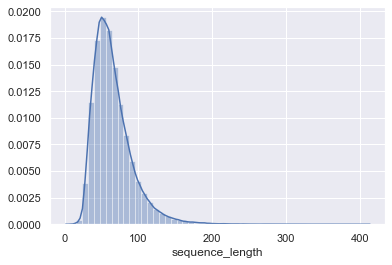

In [57]:
df=pd.DataFrame()
df["sequence_length"] = data_labels["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

## **Functions to help visualise most and least used words**

In [138]:
# Adapted from:
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
# visualize distribution of the words

def df_word(df_txt):
    df_desc = pd.DataFrame.from_dict(df_txt, orient='index', columns=['Cap1', 'Cap2', 'Cap3', 'Cap4', 'Cap5']).reset_index()
    df_desc = pd.melt(df_desc, id_vars='index', var_name='key', value_name='value')
    df_desc.rename(columns={'index':'filename', 'value':'caption'}, inplace=True)
    df_desc = df_desc.reset_index().drop(columns=['key'])
    
    #print(df_desc)
    
    df_vocabulary = []
    i=0
    for txt in df_desc.caption.values:
        # check for empty captions
        if txt != None:
            df_vocabulary.extend(txt.split())
        
    print('Vocabulary Size      : %d' % len(set(df_vocabulary)))

    ct = Counter(df_vocabulary)

    #alternative - create word & count dataframes, then merge into one
    key = pd.DataFrame(ct.keys()).reset_index().rename(columns={0:'word'})
    value = pd.DataFrame(ct.values()).reset_index().rename(columns={0:'count'})

    dfword = key.merge(value, on='index', how='inner')
    dfword = dfword.sort_values('count',ascending=False).reset_index()

    return dfword

#------------------------------------------------
# most and least frequently appearing words
import seaborn as sns
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    sns.set(style='whitegrid')
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    sns.barplot(dfsub.word,dfsub["count"])
    plt.yticks(fontsize=16)
    plt.xticks(rotation=90,fontsize=16)  #dfsub.index,dfsub["word"],
    plt.title(title,fontsize=16)
    plt.show()


### **Quick check the captions have been counted correctly**

In [175]:
print('descriptions_b4_clean:',len(descriptions_b4_clean))
dfword = df_word(descriptions_b4_clean)
dfword

descriptions_b4_clean: 31783
Vocabulary Size      : 23457


,level_0,index,word,count
0,23,23,a,181627
1,16,16,.,151037
2,27,27,A,90070
3,13,13,in,83224
4,14,14,the,57401
...,...,...,...,...
23452,14993,14993,recoiling,1
23453,14996,14996,graduated,1
23454,15003,15003,marsh-like,1
23455,15004,15004,accends,1


## **Which are the 50 Most & Least used words - before any text cleaning**

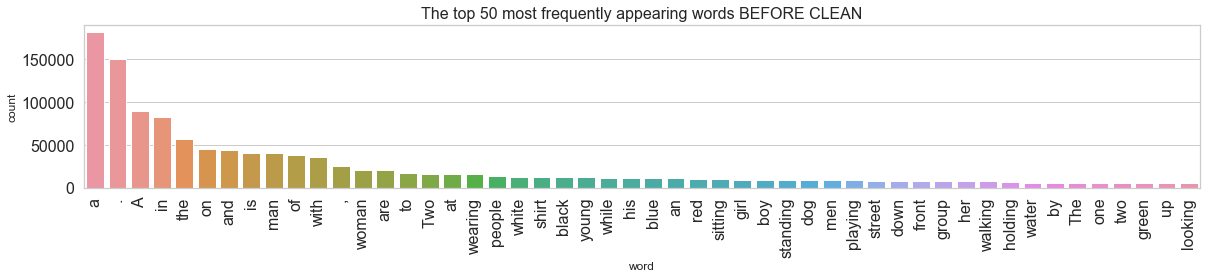

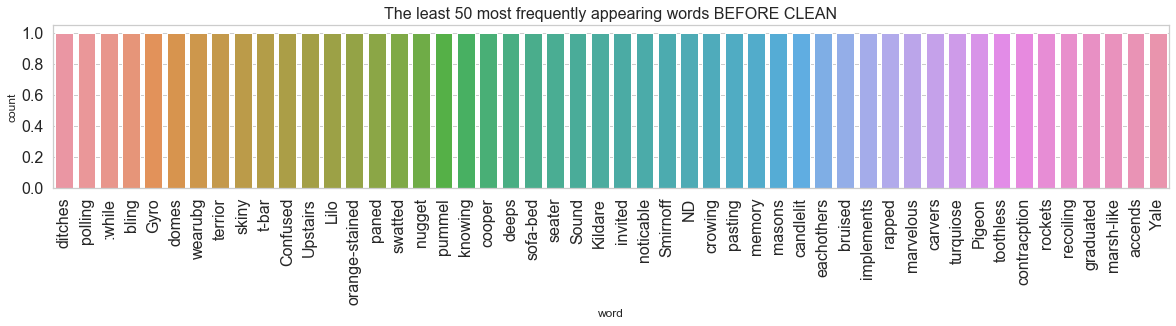

In [141]:
# BEFORE CLEAN
topn = 50

# most and least frequently appearing words
plthist(dfword.iloc[:topn,:],  title="The top 50 most frequently appearing words BEFORE CLEAN")

plthist(dfword.iloc[-topn:,:], title="The least 50 most frequently appearing words BEFORE CLEAN")

### **Which are the 50 Most & Least used words - AFTER text cleaning**

Vocabulary Size      : 19735


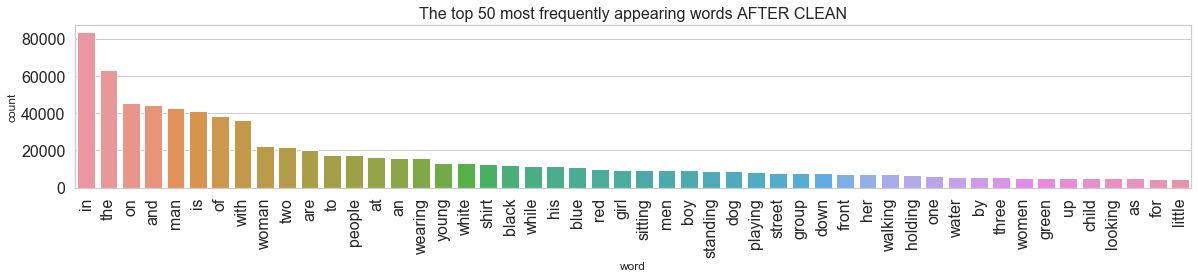

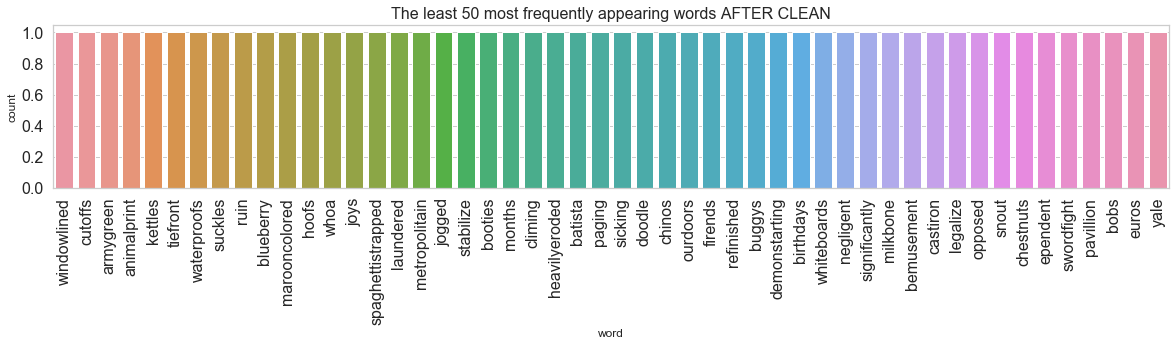

In [136]:
# AFTER CLEAN

# visualize distribution of the words
df_desc_word = df_word(descriptions)

topn = 50

# most and least frequently appearing words
plthist(df_desc_word.iloc[:topn,:],  title="The top 50 most frequently appearing words AFTER CLEAN")

plthist(df_desc_word.iloc[-topn:,:], title="The least 50 most frequently appearing words AFTER CLEAN")

### **Distribution of Avg sequence length of caption text**

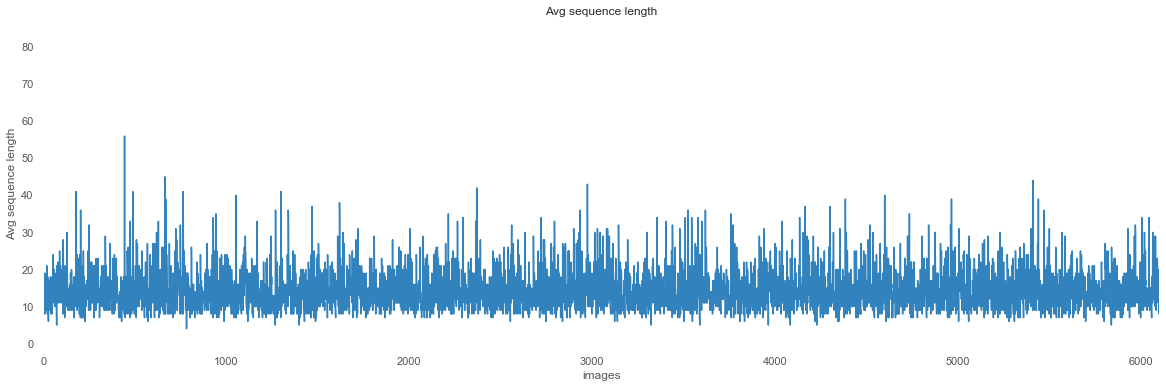

In [157]:
#https://matplotlib.org/api/artist_api.html#module-matplotlib.lines
import matplotlib as mpl

data["length"].plot(figsize=(20,6),grid=True,xlim=(0,6100))
plt.title('Avg sequence length')
plt.ylabel('Avg sequence length')
plt.xlabel('images')
plt.rcParams['axes.titlesize']  = 'large'
plt.rcParams['axes.labelsize']  = 'large' 
plt.rcParams['axes.facecolor'] = 'blue'
plt.show()

### **Display some images alongside their captions**

<class 'str'>


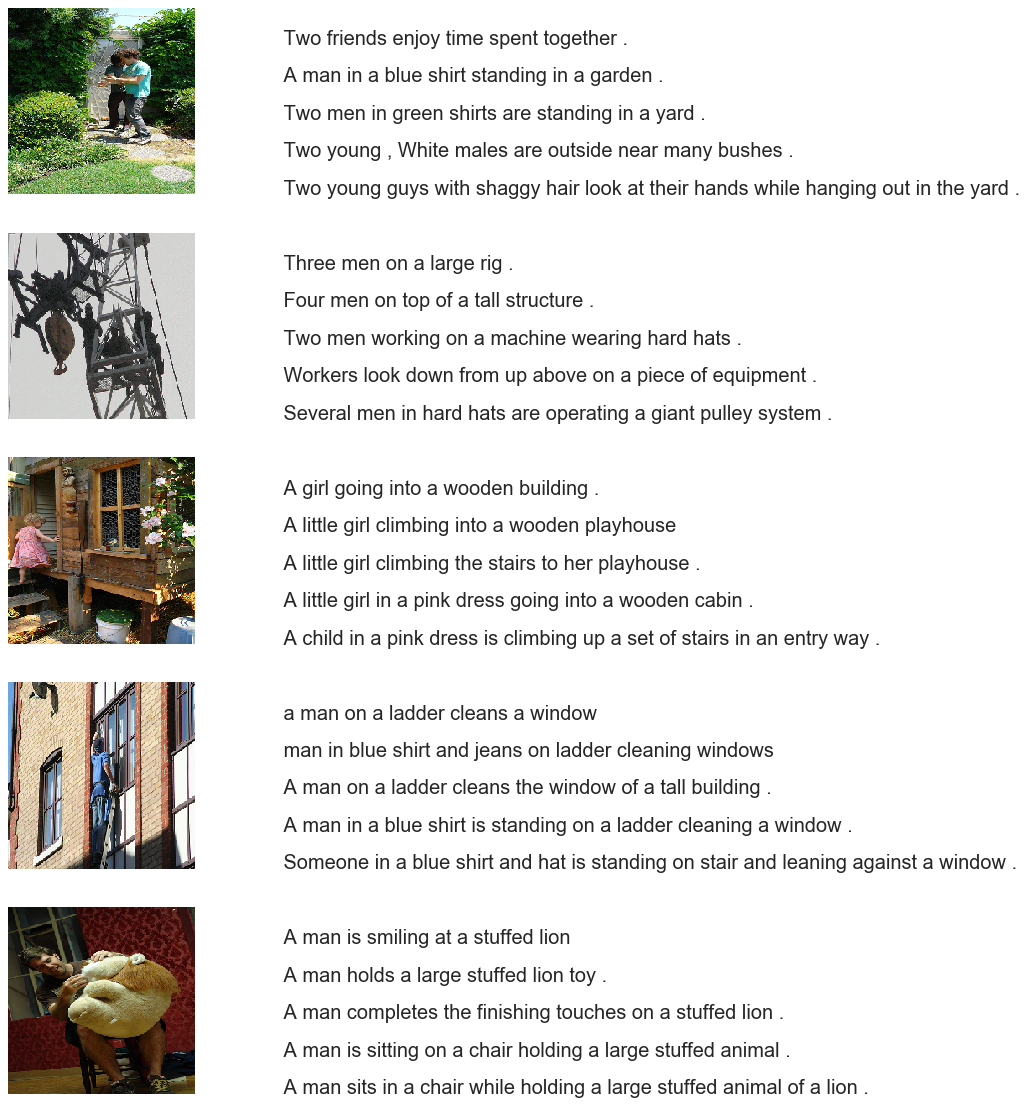

In [162]:
# Display some images with their captions
# Adapted from: https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
from keras.preprocessing.image import load_img, img_to_array

def plot_image_caption(uni_filenames, data, npic=5, npix=224):
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in uni_filenames[:npic]:
        filename = image_dir + jpgfnm 
        captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            # remove sequence swtart/end tags
            caption_text = re.sub('startseq ', '', caption)
            caption_text = re.sub(' endseq', '', caption_text)
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()


#---------------------------------------------------
uni_filenames = np.unique(train_df['filename'])
npic = 5
npix = 224

image_dir =str(image_dir)+"/flickr30k_images/"

plot_image_caption(uni_filenames, data, npic, npix,)